In [77]:
import time, sys, os
import h5py
import numpy as np
import scipy
from astropy.io import fits
from matplotlib.pyplot import *
import fsps
import sedpy
import prospect
import emcee
import dynesty
import matplotlib.pyplot as plt
from astropy.io.votable import parse
import numpy_indexed as npi
from astropy.cosmology import WMAP9 as cosmo
from astropy.cosmology import FlatLambdaCDM
from prospect.models.templates import TemplateLibrary
from prospect.fitting import lnprobfn
from prospect.fitting import fit_model
%matplotlib inline

# re-defining plotting defaults
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 20})
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

# Setup

## The data to be fit: `build_obs()`

The data to be fit is stored in a dictionary that we will call `obs`.
The `obs` dictionary stores the observed fluxes, uncertainties, and information about how those fluxes were measured.
For spectra this means the wavelengths at which the fluxes were measured, while for photometry we must know the filters through which the fluxes were measured.
This information is passed (via the `obs` dictionary) to the model object to specify which data to predict.  It is also passed to the likelihood functions for calculating the likelihood of the data for a given model.

**Units:** The units of the fluxes and uncertainties are assumed to be maggies (i.e Jy/3631).
The wavelength units are assumed to be observed frame vacuum angstroms.  Also note that mask values should be `True` for data that you want to fit, and `False` for data that is to be ignored in the likelihood calculation.

We will create an `obs` dictionary below, with all of the required keys, starting with photometry.
We will do this through a `build_obs` method, that takes some meta-parameters.
In this example we use photometry from a row in Table 2 of Johnson et al. 2013

In [78]:
# test my obj
def build_obs(snr=10, ldist=10.0, **extras):
    """Build a dictionary of observational data.  In this example 
    the data consist of photometry for a single nearby dwarf galaxy 
    from Johnson et al. 2013.
    
    :param snr:
        The S/N to assign to the photometry, since none are reported 
        in Johnson et al. 2013
        
    :param ldist:
        The luminosity distance to assume for translating absolute magnitudes 
        into apparent magnitudes.
        
    :returns obs:
        A dictionary of observational data to use in the fit.
    """
    #read data from vot table
    votable = parse('./data/zzz.vot')
    table = votable.get_first_table()
    wave=table.array['sed_freq']/10**3
    flux=table.array['sed_flux']
    err=table.array['sed_eflux']
    #if err is NAN then err = 0
    err[np.where(np.isnan(err))]=0.

    #duplicate to get the mean flux and err
    unq_wave, unq_flux = npi.group_by(wave).mean(flux)
    unq_wave, unq_err = npi.group_by(wave).mean(err)
    ind_err0=np.where(unq_err == 0)
    #if no err then set err = flux*0.2
    unq_err[ind_err0]=unq_flux[ind_err0]*0.2


    # wavelength in uinit of 10^3 GHz ##the bands we selected to use
    w1=(89.490)
    w2=(65.172)
    w3=(25.934)
    w4=(13.571)
    sdssu=(851.92)
    sdssg=(621.98)
    sdssr=(479.90)
    sdssi=(392.66)
    sdssz=(332.446)
    massj=(241.96)
    massh=(181.75)
    massk=(138.55)
    ukidssj=(240.16)
    ukidssh=(183.78)
    ukidssk=(136.21)
    galexf=(1960.7)
    galexn=(1296.7)
    spz1=(84.449)
    spz2=(66.724)
    spz3=(52.311)
    spz4=(38.083)
    spz24=(12.663)
    spz70=(4.2828)
    spz160=(1.8737)

    filters= np.array([w1,w2,w3,sdssu,sdssg,sdssr,sdssi,sdssz,massj,
                       massh,massk,ukidssj,ukidssh,ukidssk,galexf,galexn,
                      spz1,spz2,spz3,spz4,spz24,spz70,spz160])
    fnames=np.array(['wise_w1','wise_w2','wise_w3',
                     'sdss_u0','sdss_g0','sdss_r0','sdss_i0','sdss_z0',
                     'mass_j','mass_h', 'mass_k',
                     'ukidss_j','ukidss_h','ukidss_k',
                     'galex_FUV','galex_NUV',
                     'spitzer_irac_ch1', 'spitzer_irac_ch2','spitzer_irac_ch3','spitzer_irac_ch4',  
                     'spitzer_mips_24', 'spitzer_mips_70', 'spitzer_mips_160'])
    
    from prospect.utils.obsutils import fix_obs
    #get the obs index in selected filters
    indw=np.nonzero(np.in1d(unq_wave,filters))[0]
    indf=np.nonzero(np.in1d(filters,unq_wave))[0]
    wv=unq_wave[indw] # 10^3 GHz
    obs = {}
    obs["maggies"]=unq_flux[indw]/3631  #Jy/3631
    obs["maggies_unc"]=unq_err[indw]/3631  # Jy
    filternames = fnames[indf][np.argsort(filters[indf])]            
    obs["filters"] = sedpy.observate.load_filters(filternames)
    obs["phot_wave"] = np.array([f.wave_effective for f in obs["filters"]])


    #plt.plot(wv1,maggies,'ro')


    # We do not have a spectrum, so we set some required elements of the obs dictionary to None.
    data=fits.open('./data/spec-8124-56954-0690.fits')
    z=data[2].data['z'][0]
    lam=10**data[1].data['loglam']        # OBS wavelength [A]
    flux=data[1].data['flux']*3.34e4*lam**2/3631.*1.e-17 *0.9    # OBS flux [erg/s/cm^2/A] to maggies  JY/3631
    err=1./np.sqrt(data[1].data['ivar'])*3.34e4*lam**2/3631.*1.e-17   # 1 sigma error
    
    
    # (this would be a vector of vacuum wavelengths in angstroms)
    obs["wavelength"] = lam
    # (this would be the spectrum in units of maggies)
    obs["spectrum"] = smooth(flux,5)
    # (spectral uncertainties are given here)
    obs['unc'] = smooth(err,5)
    # (again, to ignore a particular wavelength set the value of the 
    #  corresponding elemnt of the mask to *False*)
    obs['mask'] = np.ones_like(lam,dtype=bool)

    # This function ensures all required keys are present in the obs dictionary,
    # adding default values if necessary
    obs = fix_obs(obs)

    return obs

run_params = {}
run_params["snr"] = 10.0
#run_params["ldist"] = 10.0
obs = build_obs(**run_params)

/Applications/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:93: RuntimeWarning: divide by zero encountered in divide


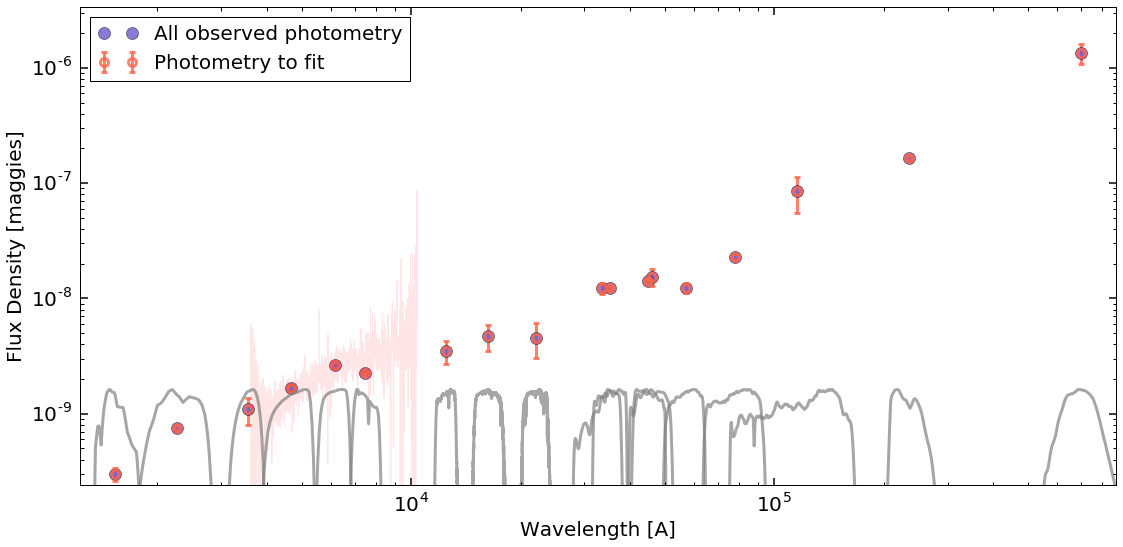

In [79]:
# --- Plot the Data ----
# This is why we stored these...
wphot = obs["phot_wave"]

# establish bounds
xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
ymin, ymax = obs["maggies"].min()*0.8, obs["maggies"].max()/0.4
figure(figsize=(16,8))

# plot all the data
plot(wphot, obs['maggies'],
     label='All observed photometry',
     marker='o', markersize=12, alpha=0.8, ls='', lw=3,
     color='slateblue')

# overplot only the data we intend to fit
mask = obs["phot_mask"]

errorbar(wphot[mask], obs['maggies'][mask], 
         yerr=obs['maggies_unc'][mask], 
         label='Photometry to fit',
         marker='o', markersize=8, alpha=0.8, ls='', lw=3,
         ecolor='tomato', markerfacecolor='none', markeredgecolor='tomato', 
         markeredgewidth=3)
plt.plot(obs['wavelength'],obs['spectrum'],'r',alpha=0.1)

# plot Filters
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)

# prettify
xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
xscale("log")
yscale("log")
legend(loc='best', fontsize=20)
tight_layout()

#TemplateLibrary.show_contents()
#TemplateLibrary.describe("alpha")

In [80]:
def build_model(object_redshift=None, ldist=10.0, fixed_metallicity=None, add_duste=False, 
                **extras):
    """Build a prospect.models.SedModel object
    
    :param object_redshift: (optional, default: None)
        If given, produce spectra and observed frame photometry appropriate 
        for this redshift. Otherwise, the redshift will be zero.
        
    :param ldist: (optional, default: 10)
        The luminosity distance (in Mpc) for the model.  Spectra and observed 
        frame (apparent) photometry will be appropriate for this luminosity distance.
        
    :param fixed_metallicity: (optional, default: None)
        If given, fix the model metallicity (:math:`log(Z/Z_sun)`) to the given value.
        
    :param add_duste: (optional, default: False)
        If `True`, add dust emission and associated (fixed) parameters to the model.
        
    :returns model:
        An instance of prospect.models.SedModel
    """
    from prospect.models.sedmodel import SedModel
    from prospect.models.templates import TemplateLibrary
    from prospect.models import priors

    # Get (a copy of) one of the prepackaged model set dictionaries.
    # This is, somewhat confusingly, a dictionary of dictionaries, keyed by parameter name
    model_params = TemplateLibrary["alpha"]
    
   # Now add the lumdist parameter by hand as another entry in the dictionary.
   # This will control the distance since we are setting the redshift to zero.  
   # In `build_obs` above we used a distance of 10Mpc to convert from absolute to apparent magnitudes, 
   # so we use that here too, since the `maggies` are appropriate for that distance.
   # model_params["lumdist"] = {"N": 1, "isfree": False, "init": ldist, "units":"Mpc"}
    
    # Let's make some changes to initial values appropriate for our objects and data
    model_params["duste_qpah"]["isfree"] = True
    model_params["duste_umin"]["isfree"] = True
    model_params["duste_gamma"]["isfree"] = True
    #model_params["dust1"]["isfree"] = True
    
    model_params["zred"]["init"] = 0.0
    model_params["dust2"]["init"] = 0.3
    model_params["logzsol"]["init"] = -0.5
    model_params["total_mass"]["init"] = 1e10
    
    # These are dwarf galaxies, so lets also adjust the metallicity prior,
    # the tau parameter upward, and the mass prior downward
    
    #model_params['z_fraction']['prior'] = priors.Beta(alpha=1.0,beta=1.0,mini=0.0,maxi=1.0)
    model_params["dust_index"]["prior"] = priors.TopHat(mini=-2.2, maxi=0.4)
    model_params["logzsol"]["prior"] = priors.TopHat(mini=-2.0, maxi=0.2)
    model_params["duste_qpah"]["prior"] = priors.TopHat(mini=0.1, maxi=10)
    model_params["duste_umin"]["prior"] = priors.TopHat(mini=0.1, maxi=25)
    model_params["duste_gamma"]["prior"] = priors.TopHat(mini=1e-6, maxi=1.0)
    model_params["dust2"]["prior"] = priors.TopHat(mini=1e-6, maxi=3.0)
    model_params["agn_tau"]["prior"] = priors.LogUniform(mini=5, maxi=1.5e2)
    model_params["total_mass"]["prior"] = priors.LogUniform(mini=1e5, maxi=1e14)


    # If we are going to be using emcee, it is useful to provide a 
    # minimum scale for the cloud of walkers (the default is 0.1)
    model_params["total_mass"]["disp_floor"] = 1e8
    model_params["agn_tau"]["disp_floor"] = 0.1
    model_params["duste_gamma"]["disp_floor"] = 0.1

    
    # Change the model parameter specifications based on some keyword arguments
    if fixed_metallicity is not None:
        # make it a fixed parameter
        model_params["logzsol"]["isfree"] = False
        #And use value supplied by fixed_metallicity keyword
        model_params["logzsol"]['init'] = fixed_metallicity 

    if object_redshift is not None:
        # make sure zred is fixed
        model_params["zred"]['isfree'] = False
        # And set the value to the object_redshift keyword
        model_params["zred"]['init'] = object_redshift

    #if add_duste:
        # Add dust emission (with fixed dust SED parameters)
        # Since `model_params` is a dictionary of parameter specifications, 
        # and `TemplateLibrary` returns dictionaries of parameter specifications, 
        # we can just update `model_params` with the parameters described in the 
        # pre-packaged `dust_emission` parameter set.
    #    model_params.update(TemplateLibrary["dust_emission"])
        
    model_params['sfh']['init']=0
    # Now instantiate the model object using this dictionary of parameter specifications
    model = SedModel(model_params)
    agebins=model_params['agebins']['init']
    model_params['agebins']['init']= prospect.models.transforms.zred_to_agebins(zred=object_redshift,agebins=agebins)
    return model


run_params["object_redshift"] = 0.82
run_params["fixed_metallicity"] = None
run_params["add_duste"] = True

Now let's build the model using this function and take a look at it:

In [81]:
model = build_model(**run_params)
print(model)
print("\nInitial free parameter vector theta:\n  {}\n".format(model.theta))
print("Initial parameter dictionary:\n{}".format(model.params))

:::::::
<class 'prospect.models.sedmodel.SedModel'>

Free Parameters: (name: prior) 
-----------
  total_mass: <class 'prospect.models.priors.LogUniform'>(mini=100000.0,maxi=1e+14)
  dust_index: <class 'prospect.models.priors.TopHat'>(mini=-2.2,maxi=0.4)
  logzsol: <class 'prospect.models.priors.TopHat'>(mini=-2.0,maxi=0.2)
  dust2: <class 'prospect.models.priors.TopHat'>(mini=1e-06,maxi=3.0)
  duste_qpah: <class 'prospect.models.priors.TopHat'>(mini=0.1,maxi=10)
  z_fraction: <class 'prospect.models.priors.Beta'>(mini=0.0,beta=[1 1 1 1 1],maxi=1.0,alpha=[5 4 3 2 1])
  duste_umin: <class 'prospect.models.priors.TopHat'>(mini=0.1,maxi=25)
  agn_tau: <class 'prospect.models.priors.LogUniform'>(mini=5,maxi=150.0)
  duste_gamma: <class 'prospect.models.priors.TopHat'>(mini=1e-06,maxi=1.0)
  fagn: <class 'prospect.models.priors.LogUniform'>(mini=1e-05,maxi=3.0)
  dust_ratio: <class 'prospect.models.priors.ClippedNormal'>(mini=0.0,maxi=2.0,sigma=0.3,mean=1.0)

Fixed Parameters: (name: value 

## The source object: `build_sps()`

We are almost there, but we need an object that will build SEDs for a given set of parameters.  In *prospector* we call these *sps* objects.  Given a dictionary of parameters (provided by the model object), they must be able to return a spectrum and photometry -- corresponding to the data in the `obs` dictionary -- and maybe some ancillary information.  The generation of spectra and photometry is often done using large spectral libraries and, for galaxies, isochrone information.  Typically in *prospector* we use `fsps.StellarPopulation` objects, under thin wrappers that add a little functionality and change the API a bit. The different wrappers correspond to different SFH parameterizations. Here we use `CSPSpecBasis` which works with (linear combinations of) composite stellar populations,  as described in the FSPS manual with `sfh_type` of 1, 4, or 5.  Other `sps` objects can be used for non-parameteric SFH, notably `prospect.sources.FastStepBasis`.

Again, it can be helpful to encapsulate the loading of the sps object in a `load_sps` method, with meta-parameters controlling the how the object is instantiated

In [82]:
def build_sps(zcontinuous=1, **extras):
    """
    :param zcontinuous: 
        A vlue of 1 insures that we use interpolation between SSPs to 
        have a continuous metallicity parameter (`logzsol`)
        See python-FSPS documentation for details
    """
    #from prospect.sources import CSPSpecBasis
    from prospect.sources import FastStepBasis
    sps = FastStepBasis(zcontinuous=zcontinuous)
    return sps

run_params["zcontinuous"] = 1
sps = build_sps(**run_params)
#help(sps.get_spectrum)

This object often has a large memory footprint, since it contains all the spectral libraries and isochrones.
It has one very important method, `get_spectrum()`.  Indeed, the only definition of an `sps` object (for example if you want to make your own) is that it have this method.  In typical use, any FSPS parameter can be passed to this method as an extra keyword argument and the model will be built using that parameter.  Several additional parameters controlling, e.g., spectral smoothing or the wavelength calibration can also be passed to the default objects.

## View the model
Now that we have the `sps` object we can also generate a prediction for the data from any set of model parameters.  To see how this works, lets make an SED and plot it!  This will use the initial parameter values for the model we built before.

Note that creating a new model with FSPS is somewhat time-intensive (of order seconds), but once the relevant SSPs have been built they are subsequently stored in cache so similar models can be generated much more quickly (of order milliseconds, unless you are changing parameters that affect the SSPs, like the IMF)

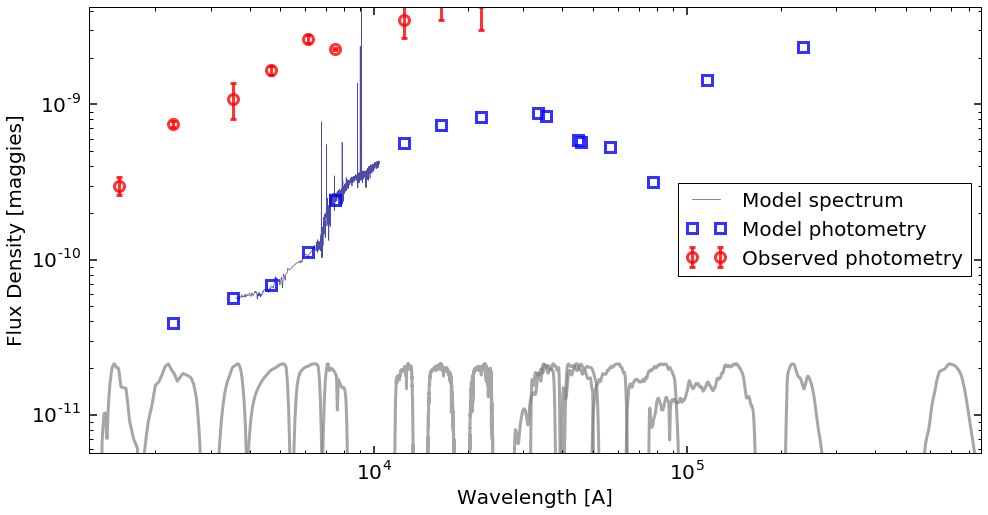

In [83]:
# Generate the model SED at the initial value of theta
theta = model.theta.copy()
initial_spec, initial_phot, initial_mfrac = model.sed(theta, obs=obs, sps=sps)
title_text = ','.join(["{}={}".format(p, model.params[p][0]) 
                       for p in model.free_params])

a = 1.0 + model.params.get('zred', 0.0) # cosmological redshifting
# photometric effective wavelengths
wphot = obs["phot_wave"]
# spectroscopic wavelengths
if obs["wavelength"] is None:
    # *restframe* spectral wavelengths, since obs["wavelength"] is None
    wspec = sps.wavelengths
    wspec *= a #redshift them
else:
    wspec = obs["wavelength"]

# establish bounds
xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
temp = np.interp(np.linspace(xmin,xmax,10000), wspec, initial_spec)
ymin, ymax = temp.min()*0.1, temp.max()/0.1
figure(figsize=(16,8))

# plot model + data
loglog(wspec, initial_spec, label='Model spectrum', 
       lw=0.7, color='navy', alpha=0.7)
errorbar(wphot, initial_phot, label='Model photometry', 
         marker='s',markersize=10, alpha=0.8, ls='', lw=3,
         markerfacecolor='none', markeredgecolor='blue', 
         markeredgewidth=3)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], 
         label='Observed photometry',
         marker='o', markersize=10, alpha=0.8, ls='', lw=3,
         ecolor='red', markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)
#title(title_text)

# plot Filters
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)

# prettify
xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
#tight_layout()


# Running Prospector
Now that we have defined the model and set up the data that we want to fit, we are ready to run *prospector*.  We will do this in a few steps.  First we will run all the convenience functions we made earlier to get the fitting ingredients and set up the output.  Then we will fit the model using 1) $\chi^2$ minimization; 2) ensemble MCMC sampler around the best location from the minimization 3) dynamic nested sampling with `dynesty`

## Minimization
We can attempt to initialize our model reasonably close to the data by using some numerical minimization routines.
Here we will use Levenberg-Marquardt. Keywords that control the optimization algorithm will again be stored in the 
`run_params` dictionary. Levenberg-Marquardt requires a likelihood function that returns a vector of chi values, not an actual likelihood, but the `lnprobfn` we imported supports that.

In [84]:

# --- start minimization ----
run_params["dynesty"] = False
run_params["emcee"] = False
run_params["optimize"] = True
run_params["min_method"] = 'lm'
# We'll start minimization from "nmin" separate places, 
# the first based on the current values of each parameter and the 
# rest drawn from the prior.  Starting from these extra draws 
# can guard against local minima, or problems caused by 
# starting at the edge of a prior (e.g. dust2=0.0)
run_params["nmin"] = 2

output = fit_model(obs, model, sps, lnprobfn=lnprobfn, **run_params)

print("Done optmization in {}s".format(output["optimization"][1]))


Done optmization in 139.294173956s


### View model after minimization
Now let's see how our model looks in the data space after minimization. The model should already be set to the result of the best optimization, but we can also find the best run and set the model parameters to that result by hand.

[ 1.00000000e+10  0.00000000e+00 -5.00000000e-01  3.00000000e-01
  4.00000000e+00  8.33333333e-01  8.00000000e-01  7.50000000e-01
  6.66666667e-01  5.00000000e-01  1.00000000e+00  5.00000000e+00
  1.00000000e-03  1.00000000e-04  1.00000000e+00]
0
[ 1.00000000e+10  0.00000000e+00 -5.00000000e-01  3.00000000e-01
  4.00000000e+00  8.33333333e-01  8.00000000e-01  7.50000000e-01
  6.66666667e-01  5.00000000e-01  1.00000000e+00  5.00000000e+00
  1.00000000e-03  1.00000000e-04  1.00000000e+00]


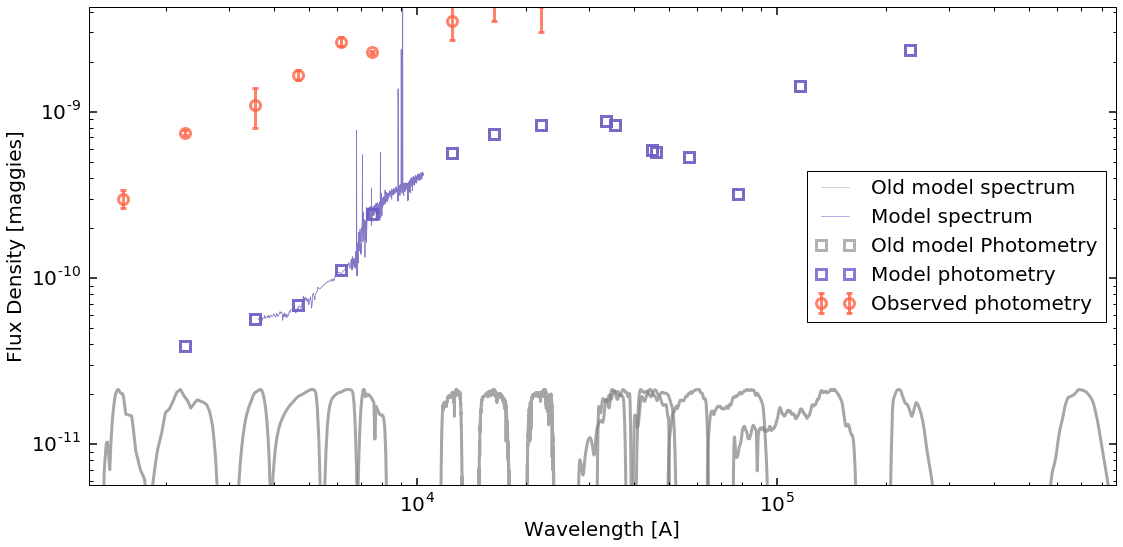

In [85]:

print(model.theta)
(results, topt) = output["optimization"]
# Find which of the minimizations gave the best result, 
# and use the parameter vector for that minimization
ind_best = np.argmin([r.cost for r in results])
print(ind_best)
theta_best = results[ind_best].x.copy()
print(theta_best)

# generate model
prediction = model.mean_model(theta_best, obs=obs, sps=sps)
pspec, pphot, pfrac = prediction

figure(figsize=(16,8))

# plot Data, best fit model, and old models
loglog(wspec, initial_spec, label='Old model spectrum',
       lw=0.7, color='gray', alpha=0.5)
errorbar(wphot, initial_phot, label='Old model Photometry', 
         marker='s', markersize=10, alpha=0.6, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='gray', 
         markeredgewidth=3)
loglog(wspec, pspec, label='Model spectrum', 
       lw=0.7, color='slateblue', alpha=0.7)
errorbar(wphot, pphot, label='Model photometry', 
         marker='s', markersize=10, alpha=0.8, ls='', lw=3,
         markerfacecolor='none', markeredgecolor='slateblue', 
         markeredgewidth=3)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'],
         label='Observed photometry', 
         marker='o', markersize=10, alpha=0.8, ls='', lw=3, 
         ecolor='tomato', markerfacecolor='none', markeredgecolor='tomato', 
         markeredgewidth=3)

# plot filter transmission curves
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)

# Prettify
xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()


That should look much better, except maybe for the filters that we have masked out.  You can also run the minimization cell multiple times to see if the fit gets better.

## Sampling the Posterior: Nested sampling
Instead of ensemble MCMC sampling we can sample using dynamic nested sampling via *dynesty*.  Dynamic nested sampling works by sampling from within successive iso-likelihood contours, transforming a distribution of live points from the prior to the posterior.  It does not benefit from burn-in via optimization.

There are a number of parameters that control the operation of *dynesty*.  A listing and brief description of each is given in the default *prospector* arguments (see below), here we will set just a few of the most important

In [86]:
# Set this to False if you don't want to do another optimization
# before emcee sampling (but note that the "optimization" entry 
# in the output dictionary will be (None, 0.) in this case)
# If set to true then another round of optmization will be performed 
# before sampling begins and the "optmization" entry of the output
# will be populated.
run_params["optimize"] = False
run_params["emcee"] = True
run_params["dynesty"] = False
# Number of emcee walkers
run_params["nwalkers"] = 30
# Number of iterations of the MCMC sampling
run_params["niter"] = 3000
# Number of iterations in each round of burn-in
# After each round, the walkers are reinitialized based on the 
# locations of the highest probablity half of the walkers.
run_params["nburn"] = [16, 32, 64]

In [87]:
output = fit_model(obs, model, sps, lnprobfn=lnprobfn, **run_params)
print('done emcee in {0}s'.format(output["sampling"][1]))

number of walkers=30
done burn #0 (16 iterations)
done burn #1 (32 iterations)
done burn #2 (64 iterations)
number of walkers=30
starting production
done production
done emcee in 26311.8782949s


In [88]:
from prospect.io import write_results as writer
hfile = "demo_emcee_mcmc_myobj.h5"
try:
    os.remove(hfile)
except:
    print 1
writer.write_hdf5(hfile, run_params, model, obs,
                  output["sampling"][0], output["optimization"][0],
                  tsample=output["sampling"][1],
                  toptimize=output["optimization"][1])

print('Finished')

Finished


## Command-line operation

The preferred way to use prospector is through command line operation.  This is difficult to demonstrate in a notebook, but essentially one would place the `build_obs`, `build_model`, and `build_sps` methods in a single **parameter file**.  Then, in the `__main__` portion of the **parameter file** the entries of the `run_params` dictionary would be set via command-line arguments (via `argparse`), the `build_*` methods would be run, and `fit_model` would be called. For an example please see `demo_params.py` and `demo_mock_params.py` in the prospector demo directory.

A number of options used by the code are available in a prebuilt argument parser, which can be augmented with anything necessary for the `build_*` methods that you create.  Below is an example.

In [89]:
from prospect import prospect_args
# - Parser with default arguments -
parser = prospect_args.get_parser()
# - Add custom arguments -
parser.add_argument('--add_duste', action="store_true",
                    help="If set, add dust emission to the model.")
parser.add_argument('--ldist', type=float, default=10,
                    help=("Luminosity distance in Mpc. Defaults to 10"
                          "(for case of absolute mags)"))
args, _ = parser.parse_known_args()
cli_run_params = vars(args)
print(cli_run_params)

{'nested_nlive_init': 100, 'verbose': 1, 'ldist': 10, 'nested_method': 'slice', 'dynesty': False, 'nested_maxbatch': 10, 'nburn': [16, 32, 64], 'nested_bootstrap': 0, 'debug': False, 'add_duste': False, 'nested_bound': 'multi', 'output_pickle': False, 'nested_posterior_thresh': 0.05, 'initial_disp': 0.1, 'outfile': 'prospector_test_run', 'zcontinuous': 1, 'nwalkers': 64, 'optimize': False, 'niter': 512, 'interval': 0.2, 'min_method': 'lm', 'nested_nlive_batch': 100, 'restart_from': '', 'nmin': 1, 'nested_dlogz_init': 0.05, 'nested_maxcall': 50000000, 'min_opts': {}, 'emcee': False}


# Visualizing the Results
There are a few basic plotting tools available to do a quick check on the results available in `prospect.io.read_results` and `prospect.utils.plotting`. But first we need to read the output files we made.

## Reading output files
Reading our results from our HDF5 file is straightforward using the `results_from` method.  This returns a "results" dictionary, the `obs` dictionary of data to which the model was fit, and in some situations the `SedModel` object that was used in the fitting.

In this example we will look at the *emcee* results file that we created, but you can do the same for the *dynesty* results file.  The main difference is that the chains for each fit type have a different dimensionality, and that the samples in the *dynesty* chains come with associated **weights**.  The weights and different shapes are handled automatically by the plotting functions included in *prospector*, but custom plotting code should take care of the difference.

In this notebook we have already defined the `model` (and `sps`) object, but in general one will want to recreate it.  *Prospector* allows you to do this by storing the `build_model` and `build_sps` code as text in the HDF5 file -- this is possible with the use of *parameter files* and command line operation.

In [90]:
import prospect.io.read_results as reader
results_type = "emcee" # | "dynesty"
# grab results (dictionary), the obs dictionary, and our corresponding models
# When using parameter files set `dangerous=True`
result, obs, _ = reader.results_from("demo_{}_mcmc_myobj.h5".format(results_type), dangerous=False)

#The following commented lines reconstruct the model and sps object, 
# if a parameter file continaing the `build_*` methods was saved along with the results
#model = reader.get_model(result)
#sps = reader.get_sps(result)

# let's look at what's stored in the `result` dictionary
print(result.keys())

[u'initial_theta', 'model', 'optimization_results', u'prospector_version', u'chain', u'theta_labels', u'sampling_duration', u'model_params', u'optimizer_duration', u'acceptance', u'rstate', u'sampling_initial_center', u'run_params', u'lnprobability', u'paramfile_text', 'obs']


## Plotting parameter traces
To see how our MCMC samples look, we can examine a few traces (that is, the evolution of the parameter value with iteration in the MCMC chain.)  You can use these plots (and the chains more generally) to assess whether the MCMC has converged, or if you need to sample for more iterations.

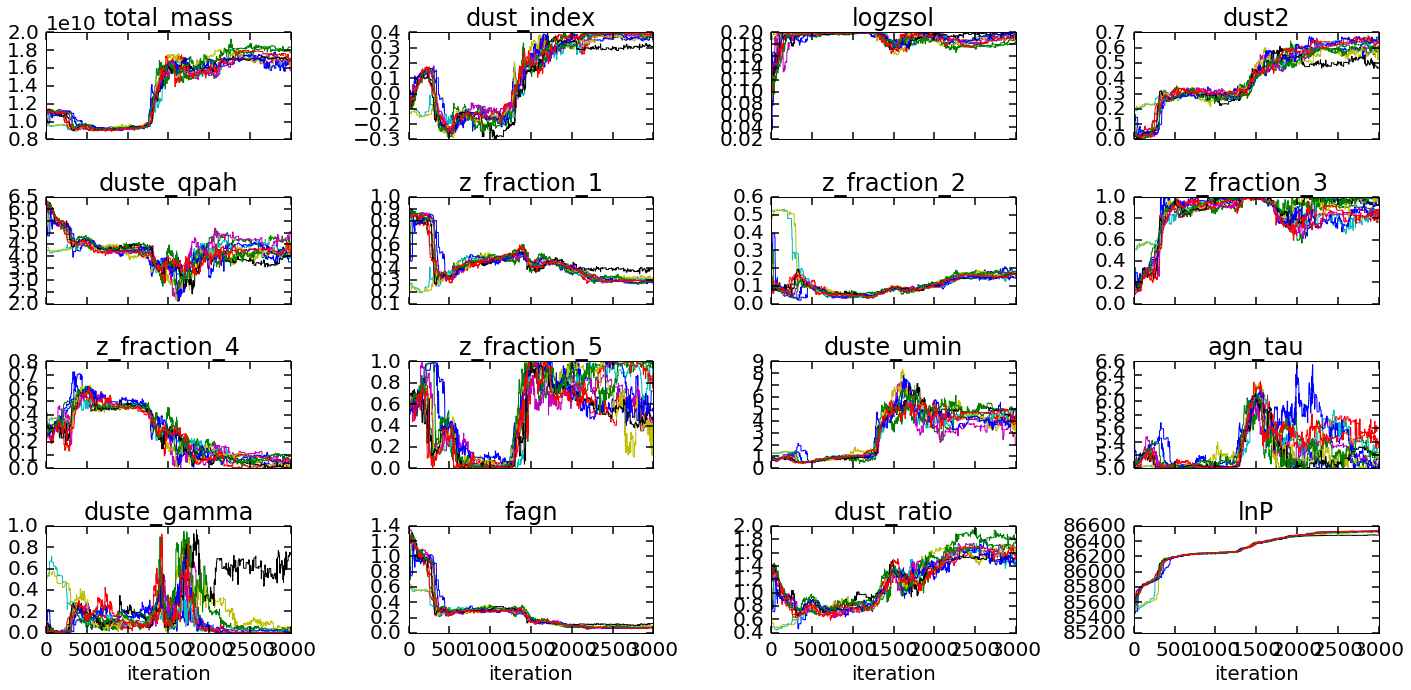

In [91]:
if results_type == "emcee":
    chosen = np.random.choice(result["run_params"]["nwalkers"], size=10, replace=False)
    tracefig = reader.traceplot(result, figsize=(20,10), chains=chosen)
else:
    tracefig = reader.traceplot(result, figsize=(20,10))


## Making a corner plot
Our samples more generally can be shown using a corner/triangle plot.  The `subtriangle()` method below is a very thin wrapper on Dan Foreman-Mackey's **corner.py** code.  We'll overplot the MAP value as blue lines.

Optimization value: [ 1.00000000e+10  0.00000000e+00 -5.00000000e-01  3.00000000e-01
  4.00000000e+00  8.33333333e-01  8.00000000e-01  7.50000000e-01
  6.66666667e-01  5.00000000e-01  1.00000000e+00  5.00000000e+00
  1.00000000e-03  1.00000000e-04  1.00000000e+00]
MAP value: [1.77245525e+10 3.71908287e-01 1.99680399e-01 6.44184599e-01
 3.83482839e+00 2.95364248e-01 1.57036296e-01 9.66846864e-01
 2.31949104e-02 7.60619043e-01 5.17252018e+00 5.38848281e+00
 5.13063662e-03 7.20933238e-02 1.58421252e+00]


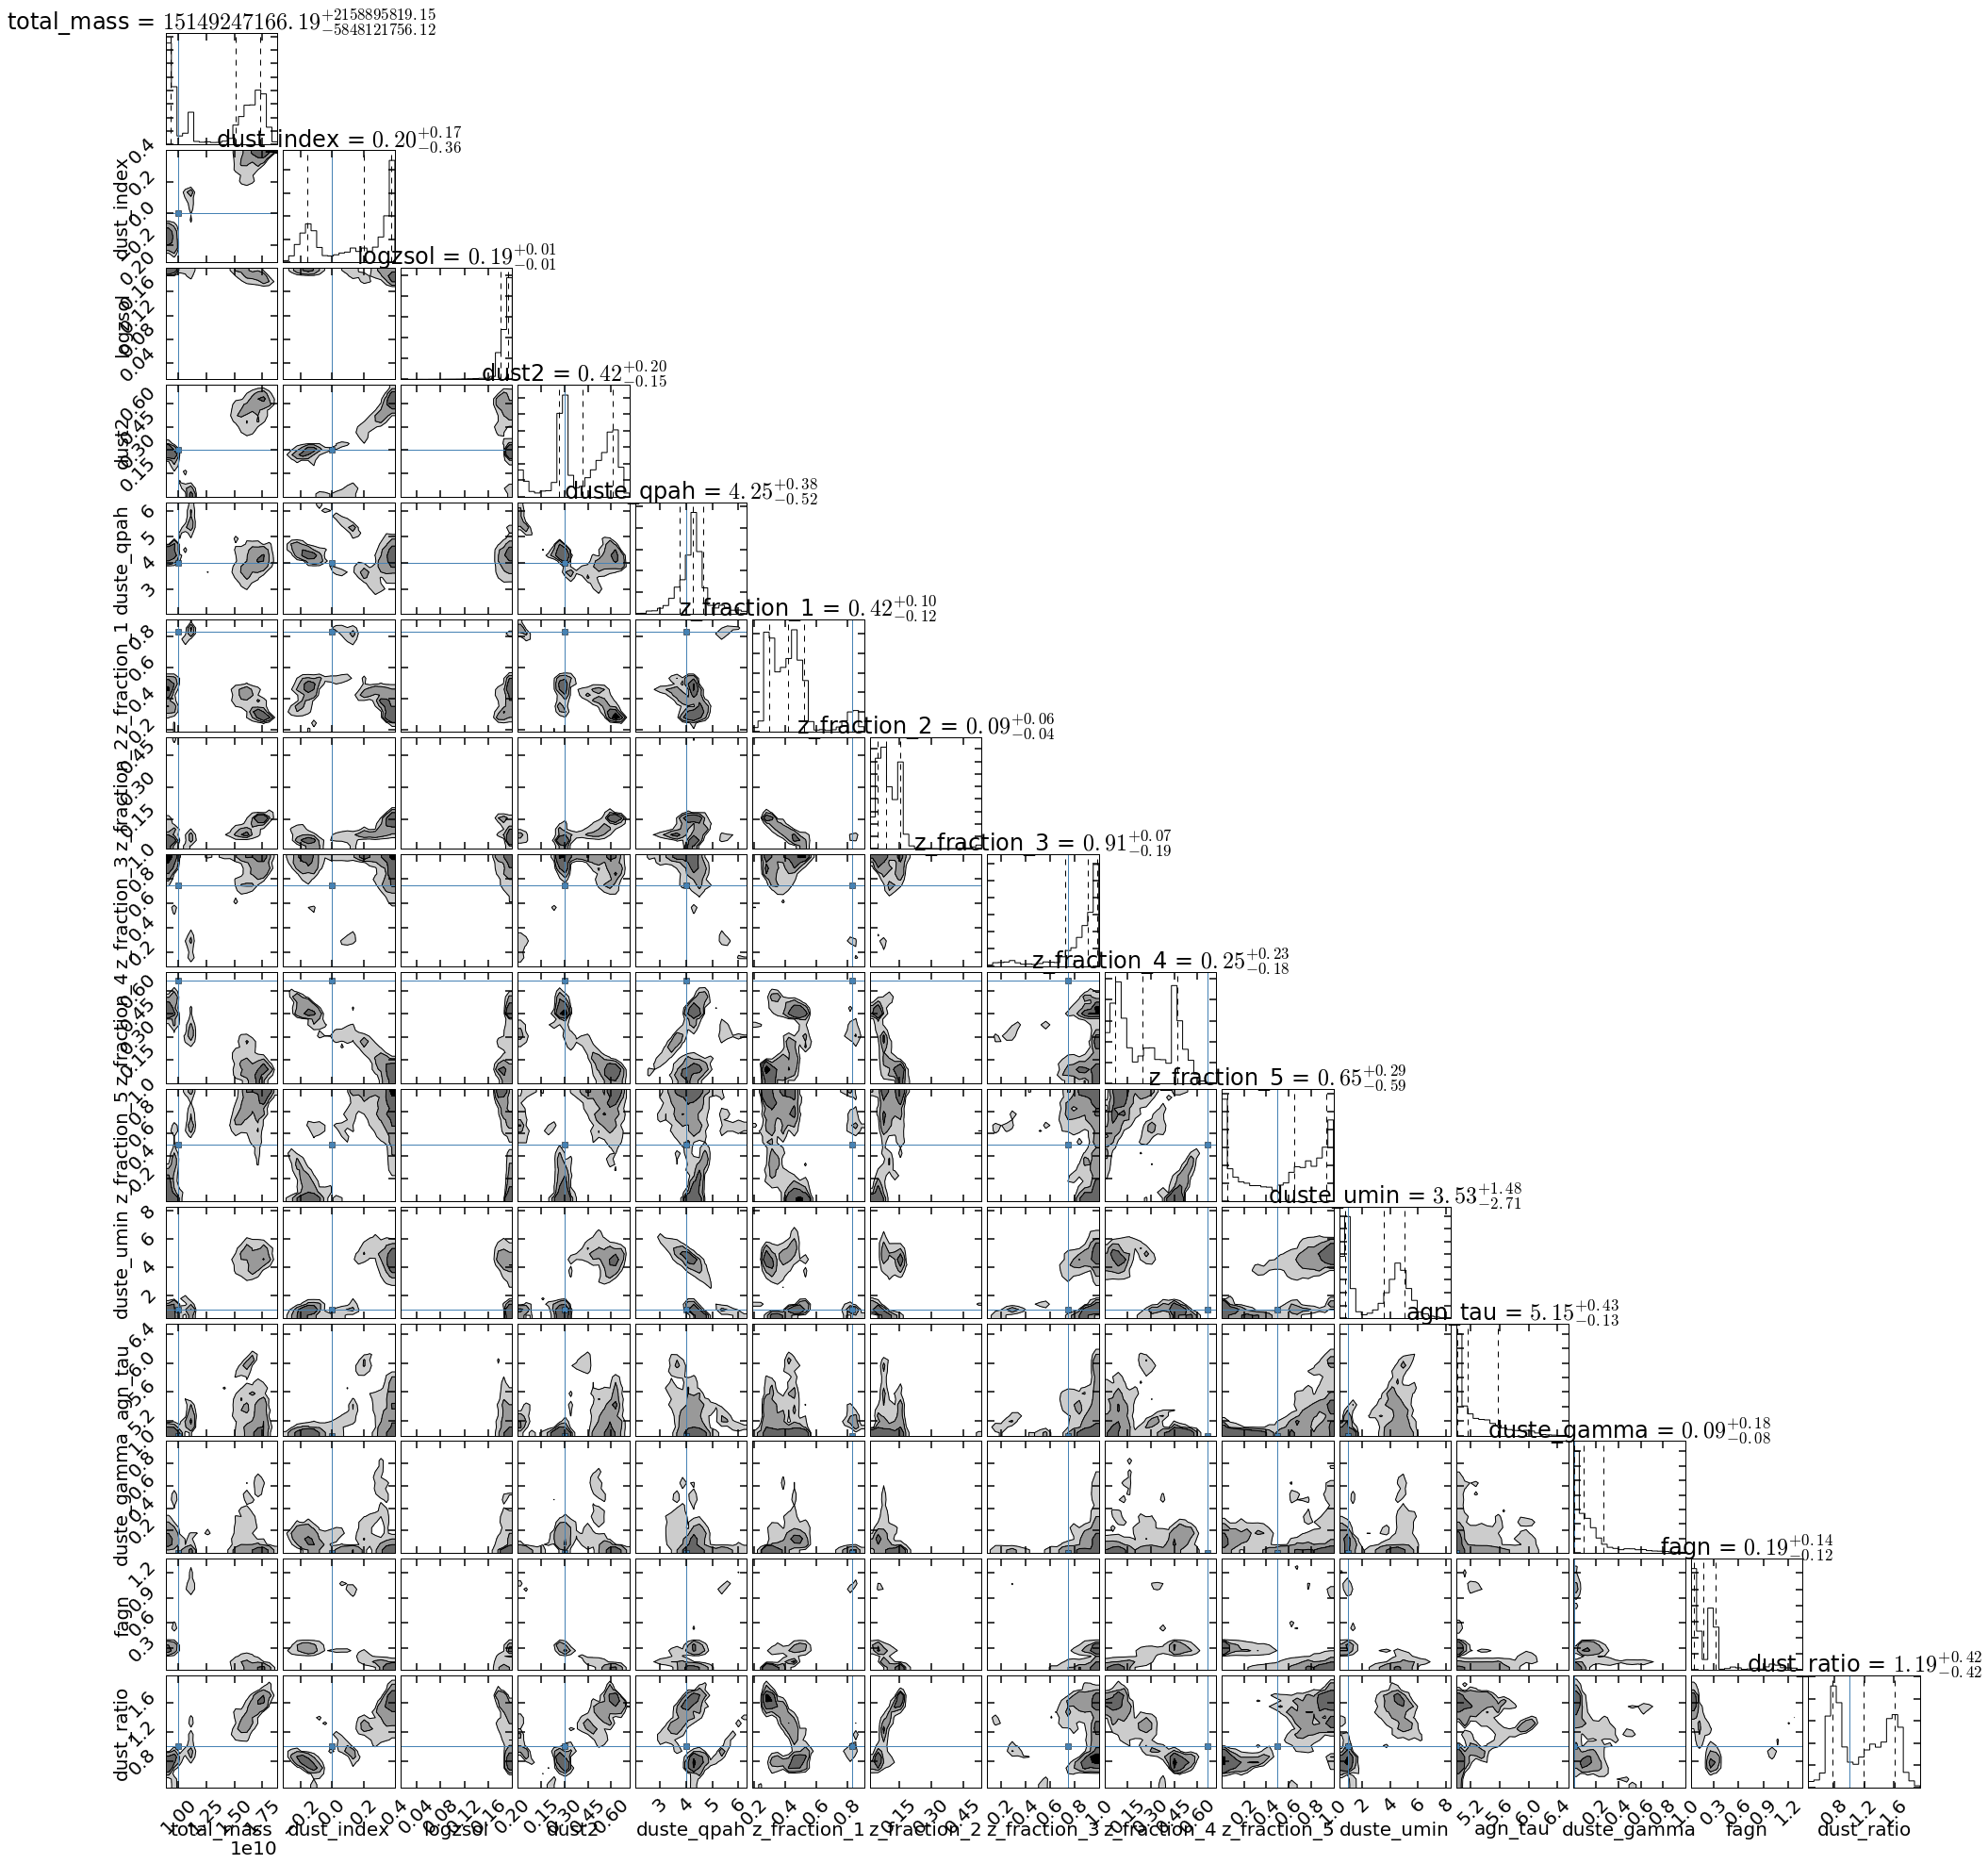

In [92]:
# maximum a posteriori (of the locations visited by the MCMC sampler)
imax = np.argmax(result['lnprobability'])
if results_type == "emcee":
    i, j = np.unravel_index(imax, result['lnprobability'].shape)
    theta_max = result['chain'][i, j, :].copy()
    thin = 5
else:
    theta_max = result["chain"][imax, :]
    thin = 1

print('Optimization value: {}'.format(theta_best))
print('MAP value: {}'.format(theta_max))


cornerfig = reader.subcorner(result, start=0, thin=thin, truths=theta_best, 
                             fig=subplots(15,15,figsize=(27,27))[0])

## Look at SEDs and residuals
Finally, let's just take a look at a random model drawn from our chains, and at the highest posterior probability model in the chain.  In this notebook we already have the `sps` object instantiated, but in general we may have to regenerate it based on information stored in the output file using the `prospect.io.read_results.get_sps` method.

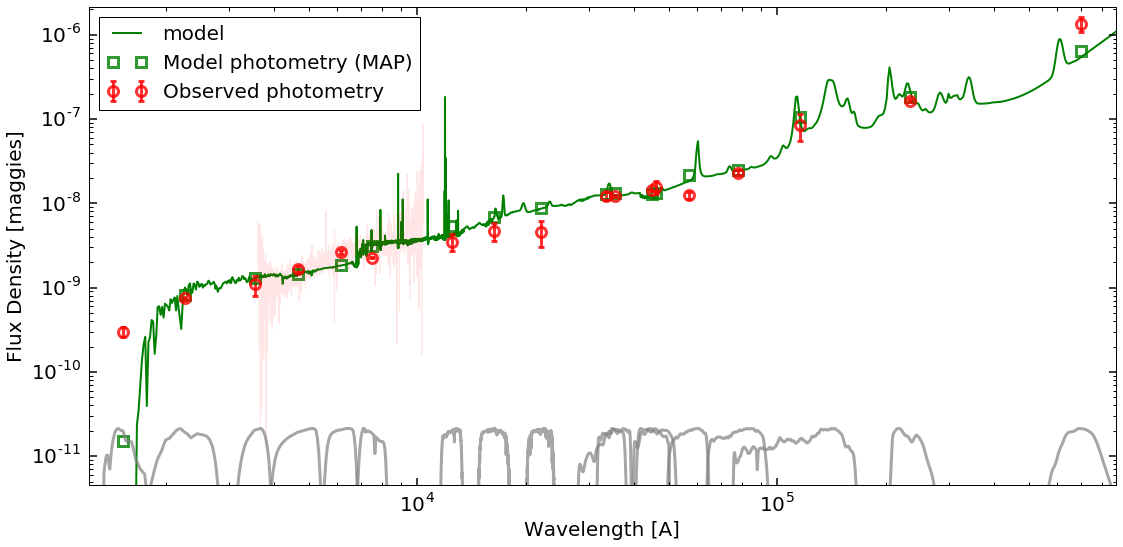

In [93]:
# randomly chosen parameters from chain
randint = np.random.randint
if results_type == "emcee":
    nwalkers, niter = run_params['nwalkers'], run_params['niter']
    theta = result['chain'][randint(nwalkers), randint(niter)]
else:
    theta = result["chain"][randint(len(result["chain"]))]

# generate models
# sps = reader.get_sps(result)  # this works if using parameter files
mspec, mphot, mextra = model.mean_model(theta, obs, sps=sps)
mspec_map, mphot_map, _ = model.mean_model(theta_max, obs, sps=sps)

# Make plot of data and model
figure(figsize=(16,8))
z=result['run_params']['object_redshift']
plt.plot(sps.wavelengths*(1+z),sps.get_spectrum()[0],'g',lw=2,alpha=1,label='model')
#loglog(wspec, mspec, label='Model spectrum (random draw)',
#       lw=0.7, color='navy', alpha=0.7)
#loglog(wspec, mspec_map, label='Model spectrum (MAP)',
#       lw=0.7, color='r', alpha=0.7)
#errorbar(wphot, mphot, label='Model photometry (random draw)',
#         marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
#         markerfacecolor='none', markeredgecolor='blue', 
#         markeredgewidth=3)
errorbar(wphot, mphot_map, label='Model photometry (MAP)',
         marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='green', 
         markeredgewidth=3)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], 
         label='Observed photometry', ecolor='red', 
         marker='o', markersize=10, ls='', lw=3, alpha=0.8, 
         markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)
plt.plot(obs['wavelength'],obs['spectrum'],'r',alpha=0.1)

# plot transmission curves
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)

xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin*0.8, ymax*500])
legend(loc='best', fontsize=20)
tight_layout()
plt.savefig('/Users/legolason/Desktop/myobj_emcee.pdf')